# Part 3: Advanced Raster Data Processing

In this assignment we will work with raster data in Python using _rasterio_ and _numpy_. We will use the _sat-search_ package to search for suitable satellite imagery from the [Amazon AWS Open Data Registry](https://registry.opendata.aws/). 

The study area of the assignment is the [Delta de Saloum](https://rsis.ramsar.org/ris/288), a Ramsar protect wetland at the coast of Senegal. We will use multi-temporal satellite imagery to monitor the changing water levels of the wetland over time.

Most of the analysis is already implemented. Just a few functions still need to be written. The main purpose of this assignment is to practice converting a notebook, in which the methodology for the study was developed, into a processing chain in form of python scripts. In this way, the analysis can be run fully automatically on different study regions without changing the parameters in the notebook each time. The processing parameters should be stored in a configuration file, so you always know which parameters have been used to run the analyses.

### Python Environment
There seem to some issues with the sat-search package and python 3.8. So you will have to set up a new anaconda environment for this assignment containing the packages in requirements.txt. 

__IMPORTANT:__ Make sure that you __use version 0.2.3 of sat-search__ using `pip install sat-search==0.2.3` and with __python=3.7.__


In [1]:
import os
import math
import numpy as np
import rasterio as rio
import pyproj
from satsearch import Search
import matplotlib.pyplot as plt
%matplotlib inline

Please refer to the following sources for information on the usage of the packages (or google it): 
* [Rasterio Python Quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html)
* [sat-search Quickstart](https://github.com/sat-utils/sat-search)
* [sat-search Python Tutorial](https://github.com/sat-utils/sat-search/blob/master/tutorial-1.ipynb)

### This analysis will include the following steps:
1. Search suitable satillite imagery using sat-search
2. Load satellite imagery
3. Convertion of raw satellite imagery to ToA reflectance
4. Calculate Water Index
5. Calculate water frequency

# Implementing a prototype of the methodology

## Step 1: Searching for suitable satellite imagery 

In the first step, we will use the package [sat-search](https://github.com/sat-utils/sat-search) to search for suitable satellite scenes within our study area and [rasterio](https://rasterio.readthedocs.io/en/latest/quickstart.html) to load the data into Python. The search is based on the Spatio-Temporal Asset Catalogs (STAC) format which should make it easier to search and query satellite imagery.  

__FYI:__ [sat-search](https://github.com/sat-utils/sat-search) is developed by [Development Seed](https://developmentseed.org/). Check out their [sat-utils on GitHub](https://github.com/sat-utils).

Let's perform a search for satellite scenes for the area of Heidelberg. You can get metadata about all scenes using the `items()` method.

### Define search parameters

The input parameters for our search for satellite scenes are:

* We are interested in all scenes from 2019-6-01 until 2020-06-01. 
* **Only Landsat 8 scenes**, since these are downloadable via Amazon AWS without an account. 
* **Maximum cloud coverage of 3%** so we get mostly cloud free scenes. 

In [2]:
#bbox = [28.859 ,44.722 ,29.868 ,45.301] 

bbox = [-16.811,13.627,-16.356,14.14]# [minx, miny, maxx, maxy]

In [3]:
time_period = '2019-06-01/2020-06-01'

In [4]:
cloud_cover = 10

In [5]:
query = {
    "eo:cloud_cover": {
        "lt": cloud_cover
    },
    "collection": {
        "eq": "landsat-8-l1"
    }
}

### Execute the search

In [6]:
search_result = Search(bbox=bbox, query=query, datetime=time_period)

The object `search_result` is of type `satsearch.search.Search` and has a method `.items()`. Execute it to get the metadata to all scenes found during the search. 

__Tipp:__ When you are working with unfamiliar classes, use frequently use the `type()` and `dir()` functions to learn about how the class works and what it can do.

In [7]:
print("{} satellite scenes were found".format(search_result.found()))

16 satellite scenes were found


In [8]:
items = search_result.items()

In [9]:
print('%s items' % len(items))
print('%s collections' % len(items._collections))
print(items._collections)

16 items
1 collections
[landsat-8-l1]


__E:__ Print a calender showing the dates on which the scenes were captured. 

In [10]:
print(items.summary())

Items (16):
date                      id                        
2020-05-29                LC82050502020150          
2020-05-13                LC82050502020134          
2020-04-27                LC82050512020118          
2020-04-27                LC82050502020118          
2020-04-11                LC82050502020102          
2020-03-26                LC82050512020086          
2020-03-26                LC82050502020086          
2020-03-10                LC82050502020070          
2020-02-07                LC82050512020038          
2020-02-07                LC82050502020038          
2020-01-06                LC82050512020006          
2020-01-06                LC82050502020006          
2019-12-21                LC82050512019355          
2019-10-18                LC82050502019291          
2019-07-30                LC82050512019211          
2019-07-30                LC82050502019211          



In [11]:
print(items.calendar())

                              2019                              

        July                 August              September      
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
 1  2  3  4  5  6  7            1  2  3  4                     1  
 8  9 10 11 12 13 14   5  6  7  8  9 10 11   2  3  4  5  6  7  8  
15 16 17 18 19 20 21  12 13 14 15 16 17 18   9 10 11 12 13 14 15  
22 23 24 25 26 27 28  19 20 21 22 23 24 25  16 17 18 19 20 21 22  
29 30 31              26 27 28 29 30 31     23 24 25 26 27 28 29  

      October               November              December      
Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su  Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6               1  2  3                     1  
 7  8  9 10 11 12 13   4  5  6  7  8  9 10   2  3  4  5  6  7  8  
14 15 16 17 18 19 20  11 12 13 14 15 16 17   9 10 11 12 13 14 15  
21 22 23 24 25 26 27  18 19 20 21 22 23 24  16 17 18 19 20 21 22  
28 29 30 31           25 26 27 28 29 30     23 24 25 26 27 28 29  

  

## Steps 2 - 4 will be testen using a single test scene before applying it to the whole study area

We will implement the whole processing chain using one of the scenes as an example. When the processing chain is up and running we will apply it to all Landsat scenes. 

In [12]:
test_item = items[2]

## Step 2: Load satellite data

First, let's create a folder to store the data. 

In [13]:
scene_dir = "./scenes"

The `os` package can help us with interactiong wiht the file system. For example, it can check whether the folder exisits. If not it will create it. 

In [14]:
if not os.path.exists(scene_dir):
    os.mkdir(scene_dir)

### Load image using rasterio

For the calculation of the water index we need the __green and short-wave infrared spectral bands__ of the satellite image. 

The `rasterio` package read images form URLs. The advantage using rasterio is that we can specify which spatial extent of the image we want to download using a `window`. This can be very useful when you want to test your method in a small test region with many images, so you don't have to download all the data.

#### 1. Get Image URLs 
Each spectral band has a unique URL through which we can download it. This information is stored in the `item.assets`. Since these are stored as a dictionary, so we can access this information using the right keys.

__E:__ Extract the URLs for the green (band 3) and short-wave infrared (band 7) spectral bands. 

In [15]:
band7_url = test_item.assets["B7"]["href"]
band3_url = test_item.assets["B3"]["href"]
band3_url

'https://landsat-pds.s3.amazonaws.com/c1/L8/205/051/LC08_L1TP_205051_20200427_20200509_01_T1/LC08_L1TP_205051_20200427_20200509_01_T1_B3.TIF'

#### 2. Convert bounding box to image coordinates

in the last notebook you've learned that the window has to be defined using image coordinates. However, our bounding box is in geogrpahic coordisntes. When we continue using rasterio we will probably need to do this kind of conversion regularly. So it would be worth writing a function for it. :) 

__E:__ Write a function which takes a bounding box with geographic coordinates as a list (same as `bbox`) and the path to the image which we would like to read. The function should return a list containing the the upper left image coordinates and the number of rows and columns. 

__Hint:__ The bounding box is given in geographic coordinates. The Landsat scene has a UTM projection. And the window needs image coordinates. So you need to go from geographic coordinates to UTM to image coordinates. `pyproj.transform` can convert point coordinates from one crs to another. In order to convert from crs to image use the functions from the last notebook. 


In [16]:
def geogr_2_image(affine,x, y):
    return ~affine * (x, y)

In [17]:
def image_2_geogr(affine,x, y):
    return affine * (x, y)

In [18]:
def get_window_for_scene(band, bbox):
    
    with rio.open(band) as src:
        affine = src.transform
        crs = src.crs
        
    ul_x, ul_y = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init=str(crs)), bbox[0], bbox[3])
    lr_x, lr_y = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init=str(crs)), bbox[2], bbox[1])
    
    ul_row, ul_col = geogr_2_image(affine, ul_x, ul_y)
    lr_row, lr_col = geogr_2_image(affine, lr_x, lr_y)
    
    ul_row = math.floor(ul_row)
    ul_col = math.floor(ul_col)
    lr_row = math.floor(lr_row)
    lr_col = math.floor(lr_col)
    rows = math.floor(lr_row - ul_row)
    cols = math.floor(lr_col - ul_col)
    
    return rio.windows.Window(ul_row, ul_col, rows, cols)

In [19]:
win = get_window_for_scene(band3_url, bbox)

/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

#### 3. Load the green (band 3) and short-wave infrared (band 7) spectral bands using rasterio

In [20]:
with rio.open(band3_url) as src:
    band3 = src.read(1, window=win, boundless=True, fill_value=65535)
    profile = src.profile

In [21]:
with rio.open(band7_url) as src:
    band7 = src.read(1, window=win, boundless=True, fill_value=65535)
    profile = src.profile

#### 4. Saving an image to file

In [22]:
#outfile = os.path.join(scene_dir, str(test_item.date), os.path.basename(band3_url))
#with rio.open(outfile, "w", **profile) as dst:
#    dst.write(band3, 1)

## Step 3: Conversion of raw satellite imagery to ToA reflectance


The spectral bands are still in raw format. Their unit is DN (digital number). But for the calculation of the NDWI we need Top-of-Atmosphere (ToA) radiance values, i.e.  the amount of radiance which reflected by the Earth's surface at the wavelength of the repective band. Therefore, we need to perform the conversion from DN to radiance using


$L_{\lambda} = M_L Q_{cal} + A_L$

$L_\lambda$ = TOA planetary reflectance, without correction for solar angle.  Note that ρλ' does not contain a correction for the sun angle.

$M_L$ = Band-specific multiplicative rescaling factor from the metadata (REFLECTANCE_MULT_BAND_x, where x is the band number)

$A_L$ = Band-specific additive rescaling factor from the metadata (REFLECTANCE_ADD_BAND_x, where x is the band number)

$Q_{cal}$ =  Quantized and calibrated standard product pixel values (DN)  

see [USGS Documentation](https://www.usgs.gov/land-resources/nli/landsat/using-usgs-landsat-level-1-data-product)



The parameters $M_L$ and $A_L$ are contained in the MTL file of each satellite image.

$M_L$ : "REFLECTANCE_MULT_BAND_"
$A_L$ : "REFLECTANCE_ADD_BAND_"

To convert an image from raw digital numbers to ToA reflectance, we need to do the following steps:
1. Download the metadata file of the satellite scene. 
2. Parse the metadata file in Python and extract the reuqired parameters.
3. Perform the conversion of the spectral bands. 

### 1. Downloading the metadata file

We've actually already done this above using

In [23]:
meta_file = test_item.download('MTL', path=os.path.join(scene_dir, "${date}"))

### 2. Reading the metadata files in Python
Let's try reading one of the metadata files using the standard `readlines()` method.

In [24]:
with open(meta_file) as src:
    metadata = src.readlines()

In [25]:
metadata

['GROUP = L1_METADATA_FILE\n',
 '  GROUP = METADATA_FILE_INFO\n',
 '    ORIGIN = "Image courtesy of the U.S. Geological Survey"\n',
 '    REQUEST_ID = "0702005089830_00012"\n',
 '    LANDSAT_SCENE_ID = "LC82050512020118LGN00"\n',
 '    LANDSAT_PRODUCT_ID = "LC08_L1TP_205051_20200427_20200509_01_T1"\n',
 '    COLLECTION_NUMBER = 01\n',
 '    FILE_DATE = 2020-05-09T04:56:11Z\n',
 '    STATION_ID = "LGN"\n',
 '    PROCESSING_SOFTWARE_VERSION = "LPGS_13.1.0"\n',
 '  END_GROUP = METADATA_FILE_INFO\n',
 '  GROUP = PRODUCT_METADATA\n',
 '    DATA_TYPE = "L1TP"\n',
 '    COLLECTION_CATEGORY = "T1"\n',
 '    ELEVATION_SOURCE = "GLS2000"\n',
 '    OUTPUT_FORMAT = "GEOTIFF"\n',
 '    SPACECRAFT_ID = "LANDSAT_8"\n',
 '    SENSOR_ID = "OLI_TIRS"\n',
 '    WRS_PATH = 205\n',
 '    WRS_ROW = 51\n',
 '    NADIR_OFFNADIR = "NADIR"\n',
 '    TARGET_WRS_PATH = 205\n',
 '    TARGET_WRS_ROW = 51\n',
 '    DATE_ACQUIRED = 2020-04-27\n',
 '    SCENE_CENTER_TIME = "11:27:22.0966320Z"\n',
 '    CORNER_UL_LAT_P

### 3. Parsing the metadata files

uh, this looks really messy. Let's try to parse the data into a dictionary, so we can extract the necessary parameters.

In [26]:
reflectance_mult = "REFLECTANCE_MULT_BAND_"
reflectance_add = "REFLECTANCE_ADD_BAND_"

__E:__ Write a function which takes the metadata (a list of tuples) and returns them as a dictionary where the keys are the parameter names and the values are the parameters values. Try to convert the values to float. If that is not possible, catch the exception with a `try: ... catch: ...` clause.

In [27]:
def parse_mtl(metadata):
    params = {}
    for x in metadata:
        entry = x.strip().split("=")
        if len(entry) == 2:
            key = entry[0].strip()
            value = entry[1].strip()
            try: 
                value = float(value)
            except:
                pass
            params[key] = value
    return params

Test whether your function is working correctly writing tests which check that the correct values are extracted from the file, e.g. 

In [28]:
parameters = parse_mtl(metadata)
assert parameters[reflectance_mult + str(3)] == 2e-05

Extract all required parameters for conversion to ToA reflectance. 

In [29]:
band3_mult = parameters[reflectance_mult + "3"]
band3_add = parameters[reflectance_add + "3"]
band7_mult = parameters[reflectance_mult + "7"]
band7_add = parameters[reflectance_add + "7"]

### 4. Conversion to reflectance
Now we that we have the parameters, we can write a function which will perform the conversion. 

__E:__ Write a function which converts the raw band to reflectance:

In [30]:
def to_toa(val, add, mult):
    return val * mult + add

__E:__ Convert the the two spectral bands to reflectance. 

In [31]:
band3_r = to_toa(band3, band3_add, band3_mult)
band7_r = to_toa(band7, band7_add, band7_mult)

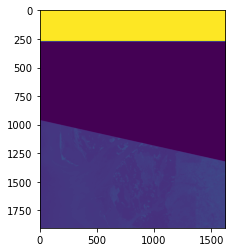

In [32]:
plt.imshow(band3_r)

## Step 4: Calculate the water index

We will use the Normalized Difference Water Index (NDWI) defined by McFeeters as an indicator for the presence of surface water.

$NDWI = \frac{L_{GREEN} - L_{SWIR}}{L_{GREEN} + L_{SWIR}}$

__E:__ Write a function which calculate the NDWI based on the green and SWIR2 (short wave infrared 2) bands. 

In [33]:
def calc_ndwi(green, swir):
    return (green - swir) / (green + swir)

In [34]:
ndwi = calc_ndwi(band3_r, band7_r)

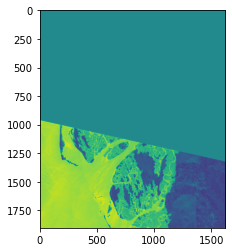

In [35]:
plt.imshow(ndwi)

## Step 5: Calculate water frequency based on the whole time series

Great! So we have the code to load and convert the satellite imagery and to calculate the NDWI of a single satellite image. Now let's put everything together in a for loop which iterates through all the Landsat scenes. We don't need the spectral bands for the further analysis, so we can just delete them and only store the numpy array containing the NDWI.

In [ ]:
FILL_VALUE = 65535
bands = []
for item in items:
    print(item)
    band3_url = item.assets["B3"]["href"]
    band7_url = item.assets["B7"]["href"]

    window = get_window_for_scene(band3_url, bbox)

    # Read metadata
    mtl_file = item.download("MTL", path=scene_dir)
    with open(mtl_file) as src:
        mtl = src.readlines()
    
    # Extract required parameters for conversion
    parameters = parse_mtl(mtl)
    band3_mult = parameters[reflectance_mult + "3"]
    band3_add = parameters[reflectance_add + "3"]
    band7_mult = parameters[reflectance_mult + "7"]
    band7_add = parameters[reflectance_add + "7"]
    
    # Read green spectral band (band 3)
    with rio.open(band3_url) as src:
        green = src.read(1, window=window, boundless=True, fill_value=FILL_VALUE)
        
    # Read sort-wave infrared spectral band (band 7)
    with rio.open(band7_url) as src:
        swir = src.read(1, window=window, boundless=True, fill_value=FILL_VALUE)
        
    # Create a binary array indicating pixels which contain valid data
    valid_pixels = np.where((green != FILL_VALUE) & (swir > 0) & (green > 0), True, False)

    # perform toa conversion
    green = to_toa(green, band3_add, band3_mult)
    swir = to_toa(swir, band7_add, band7_mult)

    # calculate ndwi
    ndwi = calc_ndwi(green, swir)
    
    # convert invalid pixels to nan
    ndwi = np.where(valid_pixels, ndwi, np.nan)
    bands.append(ndwi)

LC82050502020150


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020134


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050512020118


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020118


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020102


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050512020086


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020086


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020070


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050512020038


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020038


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050512020006


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502020006


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050512019355


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

LC82050502019291


/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/chludwig/miniconda3/envs/advgeo37/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>

__E:__ Stack the NDWI images into a 3-dimensional array. Axis 0 should indicate the time axis.

In [ ]:
bands_arr = np.array(bands)

### Calculate the water frequency
The NDWI is an indicator for the presence of water. NDWI values above 0 indicate water, below 0 land. 

__E:__ Convert the NDWI array to an array holding binary water masks using the `np.where()` method. NDWI >= 0.3 should be classified as water (1), NDWI < 0.3 as no-water (0).

In [ ]:
water_masks = np.where(bands_arr >= 0.3, 1, 0)

__E:__ Calculate the number valid pixels (not nodata) along the time axis (axis=0)

In [ ]:
valid_pixels = np.invert(np.isnan(bands)).sum(axis=0)

__E:__ Calculate the number of water pixels along the time axis (axis=0). 

In [ ]:
water_frequency = water_masks.sum(axis=0) / valid_pixels 

__E:__ Plot the water frequency using `plt.imshow()`.

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
water_freq_plot = axes.imshow(water_frequency, cmap="Blues")
plt.colorbar(mappable=water_freq_plot)

We can still see some cloud artifacts over the ocean in the right lower corner. Lower the eo:cloudcov parameter to exclude clouded scenes. 

__E:__ Show the number of valid observations. 

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(10,10))
valid_obs_plot = axes.imshow(valid_pixels, cmap="Reds")
plt.colorbar(mappable=valid_obs_plot)

Check out the full tutorial on the [sat-search github repo](https://github.com/sat-utils/sat-search) to learn about the full functionalities.

# Converting it to a python script for processing multiple regions

Congratulations! You've set up a running processing chain. But if we want to apply this method to other, maybe larger or multiple areas, it would be easier if the code was in python scripts which can be run multiple times with different parameters in an automatized way.  

So the last step of this assignment, is to convert the processing chain to a Python script 

The parameters for the satellite data search (bbox, time_period, cloud_cover) should be retrieved from a config_file, so it is always retracible which parameters you used for the data processing. 

See the files `calc_water_frequency.py` and `config.json` for templates. Fill the python file with the code from this notebook. Don't forget to apply the best-practices for scientific programming: 

* __Write tests:__ Check special cases. Satellite images often show no data values. What happens to them during the ToA conversion or when calculating the spectral index, when calculating the number valid pixels. 
* __Organize the code__ in functions and modules
* Follow the PEP8 Style guide and refactore (rename) variables for better readability
* Use git 
* ..
